In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

X_ = torch.load('../data/processed/X_fil.pt')
y_ = torch.load('../data/processed/y_fil.pt')

real_set = TensorDataset(X_, y_)

C3_eeg_feet = np.load('../data/processed/C3_eeg_feet.npy')
C4_eeg_feet = np.load('../data/processed/C4_eeg_feet.npy')
Cz_eeg_feet = np.load('../data/processed/Cz_eeg_feet.npy')

C3_eeg_feet = torch.from_numpy(np.expand_dims(C3_eeg_feet, axis=1))
C4_eeg_feet = torch.from_numpy(np.expand_dims(C4_eeg_feet, axis=1))
Cz_eeg_feet = torch.from_numpy(np.expand_dims(Cz_eeg_feet, axis=1))

eeg_feet = torch.cat((C3_eeg_feet, C4_eeg_feet, Cz_eeg_feet), 1)

C3_eeg_left_hand = np.load('../data/processed/C3_eeg_left_hand.npy')
C4_eeg_left_hand = np.load('../data/processed/C4_eeg_left_hand.npy')
Cz_eeg_left_hand = np.load('../data/processed/Cz_eeg_left_hand.npy')

C3_eeg_left_hand = torch.from_numpy(np.expand_dims(C3_eeg_left_hand, axis=1))
C4_eeg_left_hand = torch.from_numpy(np.expand_dims(C4_eeg_left_hand, axis=1))
Cz_eeg_left_hand = torch.from_numpy(np.expand_dims(Cz_eeg_left_hand, axis=1))

eeg_left_hand = torch.cat((C3_eeg_left_hand, C4_eeg_left_hand, Cz_eeg_left_hand), 1)

C3_eeg_right_hand = np.load('../data/processed/C3_eeg_right_hand.npy')
C4_eeg_right_hand = np.load('../data/processed/C4_eeg_right_hand.npy')
Cz_eeg_right_hand = np.load('../data/processed/Cz_eeg_right_hand.npy')

C3_eeg_right_hand = torch.from_numpy(np.expand_dims(C3_eeg_right_hand, axis=1))
C4_eeg_right_hand = torch.from_numpy(np.expand_dims(C4_eeg_right_hand, axis=1))
Cz_eeg_right_hand = torch.from_numpy(np.expand_dims(Cz_eeg_right_hand, axis=1))

eeg_right_hand = torch.cat((C3_eeg_right_hand, C4_eeg_right_hand, Cz_eeg_right_hand), 1)

C3_eeg_tongue = np.load('../data/processed/C3_eeg_tongue.npy')
C4_eeg_tongue = np.load('../data/processed/C4_eeg_tongue.npy')
Cz_eeg_tongue = np.load('../data/processed/Cz_eeg_tongue.npy')

C3_eeg_tongue = torch.from_numpy(np.expand_dims(C3_eeg_tongue, axis=1))
C4_eeg_tongue = torch.from_numpy(np.expand_dims(C4_eeg_tongue, axis=1))
Cz_eeg_tongue = torch.from_numpy(np.expand_dims(Cz_eeg_tongue, axis=1))

eeg_tongue = torch.cat((C3_eeg_tongue, C4_eeg_tongue, Cz_eeg_tongue), 1)

print(eeg_feet.shape)
print(eeg_left_hand.shape)
print(eeg_right_hand.shape)
print(eeg_tongue.shape)

/home/matias/Mestrado/venv_BCI/venv_BCI/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([5184, 3, 1125])
torch.Size([5184, 3, 1125])
torch.Size([5184, 3, 1125])
torch.Size([5184, 3, 1125])


In [2]:
fake = torch.cat((eeg_feet, eeg_left_hand, eeg_right_hand, eeg_tongue), 0)
y_fake = torch.cat((torch.as_tensor(np.full(5184, 0)), torch.as_tensor(np.full(5184, 1)), torch.as_tensor(np.full(5184, 2)), torch.as_tensor(np.full(5184, 3))), 0)
print(fake.shape)
print(y_fake.shape)

torch.Size([20736, 3, 1125])
torch.Size([20736])


In [3]:
fake_set = TensorDataset(fake, y_fake)

In [4]:
from torch.utils.data import random_split

fake_fulltrainset, fake_evalset = random_split(fake_set, [10368, 10368])
fake_trainset, fake_testset = random_split(fake_fulltrainset, [6912, 3456])
real_fulltrainset, real_evalset = random_split(real_set, [2592, 2592])
real_trainset, real_testset = random_split(real_fulltrainset, [1728, 864])

In [5]:
from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = False

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
n_chans = 3
input_window_samples = 1125
F1, D = 4, 2
kernel_length = 64

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    F1=8,
    D=2,
    F2=F1*D,
    kernel_length=kernel_length,
    drop_prob=0.5
)
model.to(device);

In [6]:
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

batch_size = 32
n_epochs = 50

real_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(real_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
real_clf.fit(real_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.3299        1.4359            0.3067        1.3656  0.0100  2.6236
      2            0.3895        1.3508            0.3322        1.3514  0.0100  0.2344
      3            0.3762        1.3233            0.3322        1.3310  0.0100  0.2364
      4            0.4566        1.3026            0.3900        1.2945  0.0099  0.2365
      5            0.4688        1.2903            0.4109        1.2721  0.0098  0.2382
      6            0.4560        1.2721            0.3819        1.3075  0.0097  0.2354
      7            0.5098        1.2772            0.3993        1.2726  0.0096  0.2466
      8            0.5035        1.2667            0.4190        1.2495  0.0095  0.2286
      9            0.5104        1.2388            0.4213        1.2294  0.0094  0.2329
     10            0.5122       

In [8]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 44.60%


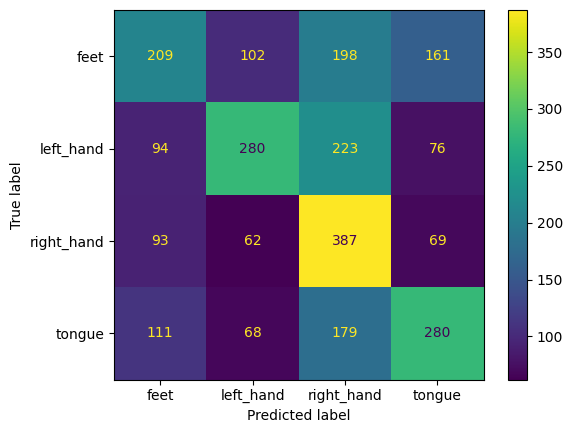

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

tsts = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=tsts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [10]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 25.49%


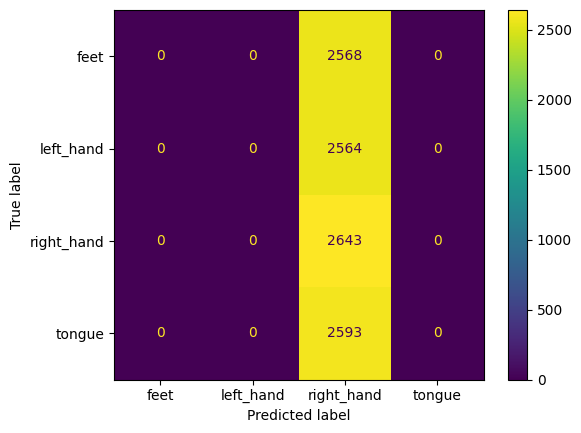

In [11]:
trts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=trts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [12]:
fake_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(fake_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
fake_clf.fit(fake_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2488        0.8662            0.2604        1.4179  0.0100  0.8736
      2            0.5137        0.8365            0.5246        0.8941  0.0100  0.8574
      3            0.5233        0.8328            0.5171        0.8148  0.0100  0.8677
      4            0.5356        0.8356            0.5420        0.8098  0.0099  0.8629
      5            0.5231        0.8307            0.5266        0.8087  0.0098  0.8913
      6            0.5107        0.8317            0.5243        0.8113  0.0097  0.8193
      7            0.4994        0.8296            0.4954        0.8161  0.0096  0.8514
      8            0.5271        0.8298            0.5260        0.8082  0.0095  0.8007
      9            0.4996        0.8294            0.5165        0.8101  0.0094  0.8692
     10            0.5035       

In [13]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 25.73%


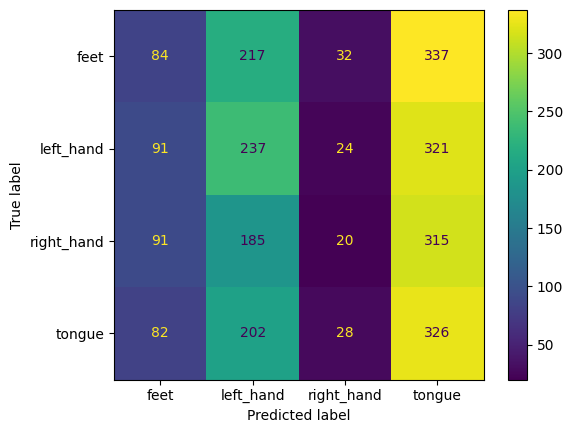

In [14]:
tstr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=tstr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [15]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 57.85%


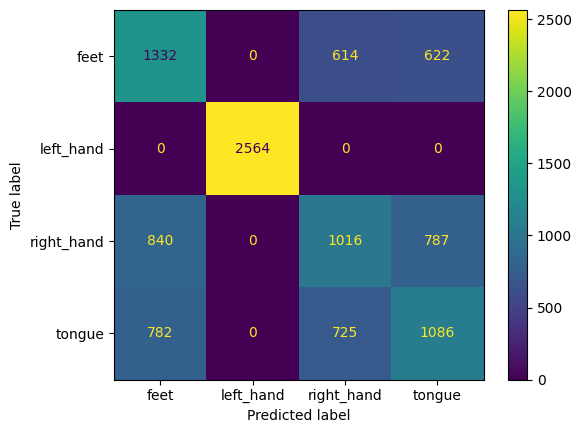

In [16]:
tsts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=tsts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [17]:
size=(3, 1125)
real = X_.view(-1, *size)

In [18]:
torch.norm(real-fake[15552:], 2)

tensor(15045.1323, dtype=torch.float64)

In [19]:
import numpy as np
from scipy import signal

window_size = 128
overlap = 64
fft_size = 128
sampling_rate = 250

spectrograms_spectrogram = []

for i in range(fake.shape[0]):
    f, t, spectrogram = signal.spectrogram(fake[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

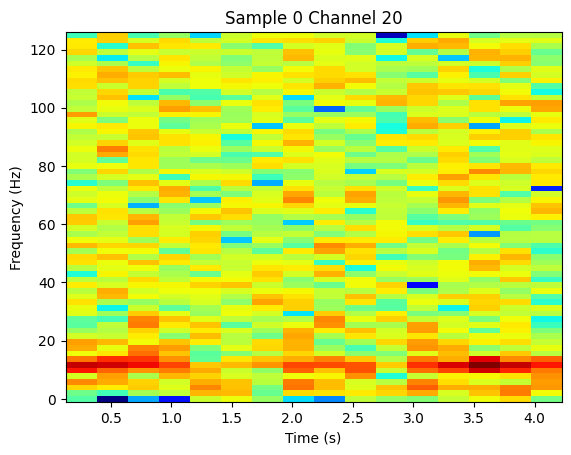

In [22]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][0, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()